In [ ]:
# #!c1.8
# %pip install eli5

In [ ]:
# %pip install optuna

In [88]:
import pandas as pd
import numpy as np
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split, GroupKFold
import time
from datetime import date as dt
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from eli5.sklearn import PermutationImportance
from eli5 import show_weights
import optuna

In [58]:
DATASET_PATH_TRAIN = 'train_merg.csv'

In [59]:
train = pd.read_csv(DATASET_PATH_TRAIN, sep=',')

In [60]:
y = train['target']
X = train.drop('target',axis=1)

In [61]:
x_train, x_valid = train_test_split(
    X, train_size=0.8, random_state=1
)
y_train, y_valid = train_test_split(
    y, train_size=0.8, random_state=1
)
print("x_train.shape = {} rows, {} cols".format(*x_train.shape))
print("x_valid.shape = {} rows, {} cols".format(*x_valid.shape))

x_train.shape = 665322 rows, 258 cols
x_valid.shape = 166331 rows, 258 cols


In [62]:
x_train=x_train.drop(['Unnamed: 0_x', 'Unnamed: 0_y'],axis=1)

In [63]:
x_valid=x_valid.drop(['Unnamed: 0_x', 'Unnamed: 0_y'],axis=1)

In [64]:
y_train=pd.DataFrame(y_train)

In [65]:
y_valid=pd.DataFrame(y_valid)

Подбор модели

In [66]:
ms_models_list = [
    lgb.LGBMClassifier(),
                  
                  cb.CatBoostClassifier(),
                  xgb.XGBClassifier()
                 ]
ms_model_metrics_df = pd.DataFrame()
for y_cur in ['target']:
    for model in ms_models_list:
        t0 = time.time()
        model_metrics_tmp = {}
        model_metrics_tmp['Y'] = y_cur
        model_metrics_tmp['Model_idx'] = ms_models_list.index(model)
        model_metrics_tmp['Model_name'] = str(type(model))
        print('Process target variable: {}.\nCurrent model: {}.'.format(y_cur, type(model)))
        model.fit(x_train, y_train)
        y_valid_pred = model.predict(x_valid)
        model_metrics_tmp['f1'] = f1_score(y_valid[y_cur].ravel(), y_valid_pred.ravel(), average='macro')
        t1 = time.time()
        model_metrics_tmp['CalcTime'] = t1 - t0
        ms_model_metrics_df = ms_model_metrics_df.append([model_metrics_tmp])

Process target variable: target.
Current model: <class 'lightgbm.sklearn.LGBMClassifier'>.
Process target variable: target.
Current model: <class 'catboost.core.CatBoostClassifier'>.
Learning rate set to 0.165336
0:	learn: 0.4391489	total: 376ms	remaining: 6m 15s
1:	learn: 0.3325125	total: 665ms	remaining: 5m 31s
2:	learn: 0.2564558	total: 989ms	remaining: 5m 28s
3:	learn: 0.2184024	total: 1.28s	remaining: 5m 18s
4:	learn: 0.1907612	total: 1.61s	remaining: 5m 20s
5:	learn: 0.1788997	total: 1.91s	remaining: 5m 15s
6:	learn: 0.1659365	total: 2.21s	remaining: 5m 14s
7:	learn: 0.1616997	total: 2.52s	remaining: 5m 12s
8:	learn: 0.1556438	total: 2.85s	remaining: 5m 13s
9:	learn: 0.1536384	total: 3.15s	remaining: 5m 12s
10:	learn: 0.1505350	total: 3.46s	remaining: 5m 10s
11:	learn: 0.1489176	total: 3.81s	remaining: 5m 14s
12:	learn: 0.1477589	total: 4.16s	remaining: 5m 15s
13:	learn: 0.1466671	total: 4.51s	remaining: 5m 17s
14:	learn: 0.1461492	total: 4.84s	remaining: 5m 17s
15:	learn: 0.1455

In [67]:
ms_model_metrics_df

,Y,Model_idx,Model_name,f1,CalcTime
0,target,0,<class 'lightgbm.sklearn.LGBMClassifier'>,0.675345,39.764027
0,target,1,<class 'catboost.core.CatBoostClassifier'>,0.691931,265.911360
0,target,2,<class 'xgboost.sklearn.XGBClassifier'>,0.659387,389.774913


Посмотрим метрики на кросс-валидации на 3-х фолдах и подберем порог вероятности

In [82]:
X['vas_id'] = X['vas_id'].astype('int8')
X['vas_id'] = X['vas_id'].astype('object')
X['buy_time'] = X['buy_time'].map(lambda x: dt.fromtimestamp(x))
X['buy_time'] = pd.to_datetime(X['buy_time'])
X = X.drop(['Unnamed: 0_x', 'Unnamed: 0_y'],axis=1)

TypeError: an integer is required (got type Timestamp)

In [ ]:
y = y.astype('int8')

In [83]:
categorical = train.dtypes[train.dtypes == "object"].index.tolist()

In [127]:
def catboost_cross_validation(params, X, y, cv, categorical= None):
   
    estimators, folds_scores = [], []
    oof_preds = np.zeros(X.shape[0])
    print(f"{time.ctime()}, Cross-Validation, {X.shape[0]}rows, {X.shape[1]} cols")
    if categorical:
        categorical = list(set(categorical) & set(X.columns))
        X[categorical] = X[categorical].astype(str)
    for fold, (train_idx, valid_idx) in enumerate(cv.split(X, y, groups = X["id"])):
        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y.loc[train_idx], y.loc[valid_idx]
        model = cb.CatBoostClassifier(**params)
        model.fit(
             x_train, y_train, categorical,
             eval_set=[(x_train, y_train), (x_valid, y_valid)]               
        )
        oof_preds[valid_idx] = model.predict_proba(x_valid)[:, 1]
        score = f1_score(y_valid, model.predict(x_valid), average='macro')
        print(f"Fold{fold+1}, Valid_score = {round(score, 5)}")
        folds_scores.append(round(score, 5))
        estimators.append(model)
        
    print(f"Score by each fold: {folds_scores}")
    print("="*65)
    return estimators, oof_preds, folds_scores

In [85]:
scale = int(y[y == 0].shape[0] / y[y == 1].shape[0])
scale

12

In [128]:
cb_params = {'silent': True, 
            'scale_pos_weight': scale,
            
}



cv = GroupKFold(n_splits=3)
estimators, oof_preds, folds_scores=catboost_cross_validation(
    params=cb_params, X=X, y=y, cv=cv, categorical=categorical)

Tue Mar  1 17:07:14 2022, Cross-Validation, 831653rows, 256 cols
Fold1, Valid_score = 0.71381
Fold2, Valid_score = 0.71332
Fold3, Valid_score = 0.7139
Score by each fold: [0.71381, 0.71332, 0.7139]


In [129]:
pd.Series(folds_scores).mean()

0.7136766666666666

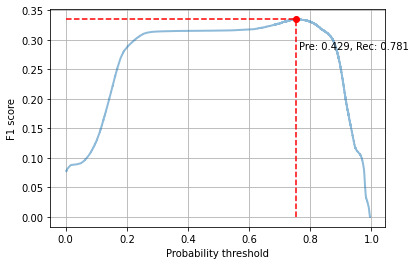

In [131]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
# Plot the class probabilities for the unlabeled samples

precision, recall, th = precision_recall_curve(y, oof_preds)
f1s = precision[:-1]*recall[:-1]
plt.plot(th, f1s, linewidth=2, alpha=0.5)
best_th = np.argmax(f1s)
plt.plot(th[best_th], f1s[best_th], c='r', marker='o')
plt.plot([th[best_th], th[best_th]], [0.0,f1s[best_th] ], 'r--')
plt.plot([0.0, th[best_th]], [f1s[best_th], f1s[best_th] ], 'r--')
plt.annotate('Pre: %0.3f, Rec: %0.3f' %(precision[best_th], recall[best_th]), 
             xy=(th[best_th]+ 0.01, f1s[best_th]-0.05))
plt.xlabel('Probability threshold')
plt.ylabel('F1 score')
plt.grid()


Посмотрим важность признаков

In [103]:
#!c1.8
train = pd.read_csv(DATASET_PATH_TRAIN, sep=',')

In [104]:
#!c1.8
y = train['target']
X = train.drop(['Unnamed: 0_x', 'Unnamed: 0_y', 'target'],axis=1)

In [105]:
#!c1.8
params = {'silent': True, 
            'scale_pos_weight': scale
}


model = cb.CatBoostClassifier(**params)
model.fit(X, y)


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


In [106]:
#!c1.8
estimator = PermutationImportance(
    model, scoring="f1", random_state=27
)
importance = estimator.fit(X, y)

KeyboardInterrupt: 

In [ ]:
show_weights(importance, feature_names=X.columns.tolist(), top=X.shape[1])

Подберем оптимальные параметры

In [108]:
def objective(trial):
    train_x, valid_x, train_y, valid_y = train_test_split(X, y, test_size=0.3, random_state=42)

    param = {
         'n_estimators': trial.suggest_int("n_estimators", 1000, 10000),
        "learning_rate": trial.suggest_float("learning_rate", 0.0001, 0.1),
        "eval_metric": "F1",
        "depth": trial.suggest_int("depth", 1, 12),
       
    }

   
        

    estimators[2].fit(train_x,
            train_y,
            categorical,
            eval_set=[(valid_x, valid_y)],
            verbose=0,
            early_stopping_rounds=100,
            )

    preds = estimators[2].predict(valid_x)
    score = f1_score(valid_y, preds, average='macro')
    return  score

In [109]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

[I 2022-03-01 16:20:17,572] A new study created in memory with name: no-name-80d21f21-c4f6-4249-bbb7-83d52484d1a5
/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)
[I 2022-03-01 16:21:47,241] Trial 0 finished with value: 0.7146600547983972 and parameters: {'n_estimators': 7385, 'learning_rate': 0.010452371221948819, 'depth': 3}. Best is trial 0 with value: 0.7146600547983972.
[I 2022-03-01 16:22:50,550] Trial 1 finished with value: 0.7146600547983972 and parameters: {'n_estimators': 4333, 'learning_rate': 0.033561879871909825, 'depth': 10}. Best is trial 0 with value: 0.7146600547983972.
[I 2022-03-01 16:23:53,9

KeyboardInterrupt: 